In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import json

# Visualization
import matplotlib.pyplot as plt 
from wordcloud import WordCloud
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter

from sklearn import feature_extraction, linear_model, model_selection, preprocessing

# Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# NLP
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import wordpunct_tokenize
from nltk.corpus import words, stopwords, wordnet
from nltk.tokenize import RegexpTokenizer

# Import regex and time
import re
import time

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel, LdaModel
from gensim.models import Phrases

import emoji

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this

# Disable deprecation warnings
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

d:\Formation_IA\P6_avis_restau\avis_restau_venv\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload


In [2]:
df = pd.read_csv("bad_reviews.csv")

In [3]:
df.head(5)

,stars,text
0,2,"We started with the artichoke dip, big mistake..."
1,1,"If I could give it a zero, I would. I order a ..."
2,1,Skip this train wreck if you are looking for d...
3,1,Service and management terrible... After messi...
4,1,Pretty slow service and the waitresses aren't ...


In [4]:
print(f"The dataframe is composed of {df.shape[0]} rows and {df.shape[1]} columns.")

The dataframe is composed of 185034 rows and 2 columns.


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185034 entries, 0 to 185033
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   stars   185034 non-null  int64 
 1   text    185034 non-null  object
dtypes: int64(1), object(1)
memory usage: 2.8+ MB


In [6]:
df.isna().sum()

stars    0
text     0
dtype: int64

In [7]:
df.duplicated(subset=["text"]).sum()

314

In [8]:
df[df.duplicated(subset=["text"])]

,stars,text
2320,1,Certainly not worth the price. IMO food was no...
4214,2,"The service at Han Dynasty, Exton, was awful. ..."
4760,1,We did not get a good experience from the star...
4822,1,I was very unhappy with my last stay at Hard R...
6438,2,This coffee shop is NOT what Nashville is abou...
...,...,...
182915,2,I once frequented this place for its outstandi...
183018,1,The food is ok but the service sucks they nee...
183241,1,DO NOT GO HERE!! This spot is the dirtiest res...
184185,2,"Not welcoming hosts, waitress did not comprehe..."


In [9]:
df.duplicated().sum()

297

In [10]:
df[df.duplicated()]

,stars,text
2320,1,Certainly not worth the price. IMO food was no...
4214,2,"The service at Han Dynasty, Exton, was awful. ..."
4822,1,I was very unhappy with my last stay at Hard R...
6438,2,This coffee shop is NOT what Nashville is abou...
6441,2,This place has really gone downhill from what ...
...,...,...
182915,2,I once frequented this place for its outstandi...
183018,1,The food is ok but the service sucks they nee...
183241,1,DO NOT GO HERE!! This spot is the dirtiest res...
184185,2,"Not welcoming hosts, waitress did not comprehe..."


In [11]:
df.isna().mean().sort_values()

stars    0.0
text     0.0
dtype: float64

In [12]:
# Take sample of dataset

data = df.sample(n=5000, replace=False)

In [13]:
data = data.reset_index().drop(columns=["index", "stars"])

## Document clean-up

In [14]:
def display_tokens_info(tokens):
    print(f"nb tokens {len(tokens)}, nb tokens uniques {len(set(tokens))}")
    print(tokens[:30])

We use the WordNet lemmatizer from NLTK. A lemmatizer is preferred over a stemmer in this case because it produces more readable words. Output that is easy to read is very desirable in topic modelling.

In [15]:
stop_words = set(stopwords.words('english'))
lem = WordNetLemmatizer()
tokenizer = nltk.RegexpTokenizer(r'[a-zA-Z]+')

def text_cleaner(text):

    text = emoji.demojize(text, delimiters=("", "")) # demojize the emojis in the docs

    text = text.lower() # to lowercase
    
    text = tokenizer.tokenize(text) # tokenize with regular expressions

    text = [w for w in text if w not in stop_words] # remove stopwords

    text = [lem.lemmatize(w) for w in text] # lemmatize with WordNetLemmatizer

    text = [w for w in text if len(w) > 2] # keep only words longer than 2 characters

    ### keep only nouns

    pos_tag = nltk.pos_tag(text)
    noun_text = []

    for i in range (0, (len(text)-1)):

        if (pos_tag[i][1] == 'NN'):
            noun_text.append(pos_tag[i][0])

    text = noun_text

    ###

    return text

In [16]:
data["clean_text"] = data["text"].apply(lambda row : text_cleaner(row))

In [17]:
data

,text,clean_text
0,We made 7:15 reservations and arrived a few mi...,"[reservation, problem, greet, minute, water, d..."
1,Went for dinner with several people. Only had ...,"[price, lobster, burger, lobster, mac, cream, ..."
2,Either people here are insane or the water is ...,"[water, food, crap, excuse, food, matter, food..."
3,"We used to love this place, but lately somethi...","[place, something, order, day, order, menu, ru..."
4,What makes a Bistro a Bistro? I have begun to ...,"[bistro, bistro, linen, table, cloth, street, ..."
...,...,...
4995,I had a horrible experience at this restaurant...,"[experience, restaurant, party, move, table, b..."
4996,I made reservation on 5/29 through hotels.com....,"[reservation, hotel, com, payment, hotel, com,..."
4997,"Wow, not sure what happened, different manager...","[manager, employee]"
4998,I asked the wait staff about vegan options and...,"[staff, vegan, option, kind, clueless, defense..."


## Check our progress

In [18]:
corpus = wordpunct_tokenize(" ".join(data.text.values))
corpus_clean = np.concatenate(data.clean_text)

In [19]:
print(f"Unique tokens before cleaning: {len(set(corpus))}")
print(f"Unique tokens after cleaning: {len(set(corpus_clean))}")

Unique tokens before cleaning: 21020
Unique tokens after cleaning: 7690


### Corpus before cleaning

In [20]:
display_tokens_info(corpus)

nb tokens 727144, nb tokens uniques 21020
['We', 'made', '7', ':', '15', 'reservations', 'and', 'arrived', 'a', 'few', 'minutes', 'early', '.', 'They', 'seated', 'us', 'immediately', 'and', 'that', 'is', 'where', 'the', 'problems', 'started', '.', 'It', 'took', 'forever', 'to', 'have']


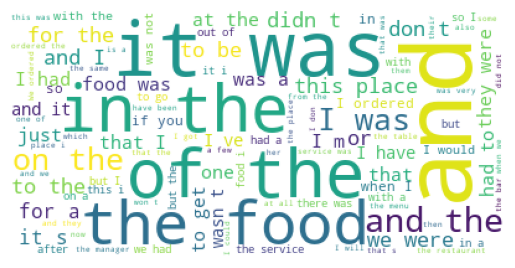

In [21]:
wordcloud = WordCloud(background_color='white',
                        stopwords=[],
                        max_words=100).generate(" ".join(corpus))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

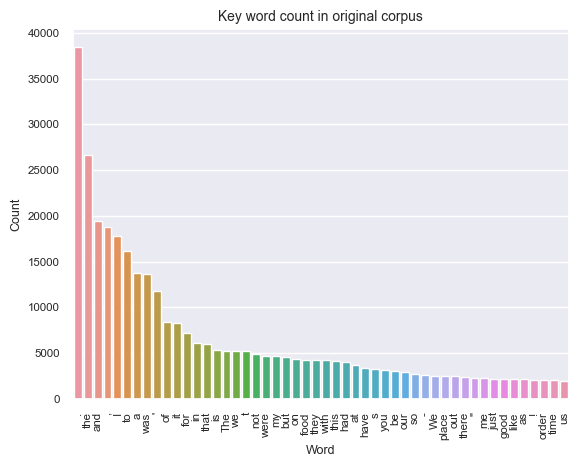

In [22]:
# Bar plot - Create a dataframe of the most common 30 words
common_words = pd.DataFrame(Counter(corpus).most_common(50))
common_words.columns = ('Word', 'Count')# Plot a bar chart of the most common 20 words
sns.set(font_scale = 0.75)
sns.barplot(x= common_words['Word'], y=common_words['Count'])
plt.xticks(rotation='vertical')
plt.title("Key word count in original corpus", fontsize = 10)
plt.show()

### Corpus after cleaning

In [23]:
display_tokens_info(corpus_clean)

nb tokens 118925, nb tokens uniques 7690
['reservation' 'problem' 'greet' 'minute' 'water' 'drink' 'order' 'forgot'
 'lemon' 'minute' 'server' 'table' 'server' 'clue' 'minute' 'thing'
 'better' 'service' 'level' 'manager' 'complaint' 'food' 'side' 'trip'
 'year' 'location' 'price' 'lobster' 'burger' 'lobster']


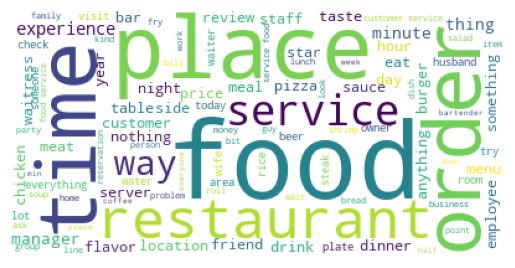

In [24]:
wordcloud = WordCloud(background_color='white',
                        max_words=100).generate(" ".join(corpus_clean))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

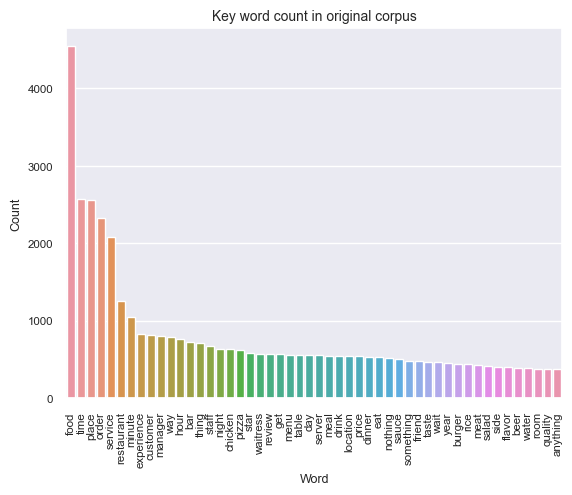

In [25]:
# Bar plot - Create a dataframe of the most common 30 words
common_words = pd.DataFrame(Counter(corpus_clean).most_common(50))
common_words.columns = ('Word', 'Count')# Plot a bar chart of the most common 20 words
sns.set(font_scale = 0.75)
sns.barplot(x= common_words['Word'], y=common_words['Count'])
plt.xticks(rotation='vertical')
plt.title("Key word count in original corpus", fontsize = 10)
plt.show()

In [26]:
common_words = ["food", "time", "place", "order", "service", "restaurant", "minute"]

data.clean_text = data.clean_text.apply(lambda row : [w for w in row if w not in common_words])

## Form Bigrams

In [27]:
data["w_bigrams"] = data.clean_text

before_bigrams = len(np.concatenate(data.w_bigrams))

bigram = Phrases(data.w_bigrams, min_count=5, threshold=100)
for idx in range(len(data.w_bigrams)):
    for token in bigram[data.w_bigrams[idx]]:
        if '_' in token:
            data.w_bigrams[idx].append(token)

after_bigrams = len(np.concatenate(data.w_bigrams))

print(f"We added "+ str(after_bigrams - before_bigrams) + " bigrams.")

We added 964 bigrams.


## Form Trigrams

In [28]:
data["w_trigrams"] = data.w_bigrams

before_trigrams = len(np.concatenate(data.w_trigrams))

trigram = Phrases(data.w_trigrams, min_count=5, threshold=100)
for idx in range(len(data.w_trigrams)):
    for token in trigram[data.w_trigrams[idx]]:
        if '_' in token:
            data.w_trigrams[idx].append(token)

after_trigrams = len(np.concatenate(data.w_trigrams))

print(f"We added "+ str(after_trigrams - before_trigrams) + " trigrams.")

We added 1911 trigrams.


In [29]:
data

,text,clean_text,w_bigrams,w_trigrams
0,We made 7:15 reservations and arrived a few mi...,"[reservation, problem, greet, water, drink, fo...","[reservation, problem, greet, water, drink, fo...","[reservation, problem, greet, water, drink, fo..."
1,Went for dinner with several people. Only had ...,"[price, lobster, burger, lobster, mac, cream, ...","[price, lobster, burger, lobster, mac, cream, ...","[price, lobster, burger, lobster, mac, cream, ..."
2,Either people here are insane or the water is ...,"[water, crap, excuse, matter, rung, garbage, p...","[water, crap, excuse, matter, rung, garbage, p...","[water, crap, excuse, matter, rung, garbage, p..."
3,"We used to love this place, but lately somethi...","[something, day, menu, rude, pleasant, custome...","[something, day, menu, rude, pleasant, custome...","[something, day, menu, rude, pleasant, custome..."
4,What makes a Bistro a Bistro? I have begun to ...,"[bistro, bistro, linen, table, cloth, street, ...","[bistro, bistro, linen, table, cloth, street, ...","[bistro, bistro, linen, table, cloth, street, ..."
...,...,...,...,...
4995,I had a horrible experience at this restaurant...,"[experience, party, move, table, bug, window, ...","[experience, party, move, table, bug, window, ...","[experience, party, move, table, bug, window, ..."
4996,I made reservation on 5/29 through hotels.com....,"[reservation, hotel, com, payment, hotel, com,...","[reservation, hotel, com, payment, hotel, com,...","[reservation, hotel, com, payment, hotel, com,..."
4997,"Wow, not sure what happened, different manager...","[manager, employee]","[manager, employee]","[manager, employee]"
4998,I asked the wait staff about vegan options and...,"[staff, vegan, option, kind, clueless, defense...","[staff, vegan, option, kind, clueless, defense...","[staff, vegan, option, kind, clueless, defense..."


In [30]:
data["docs"] = data.clean_text.apply(lambda x : " ".join(x))
data.head(5)

,text,clean_text,w_bigrams,w_trigrams,docs
0,We made 7:15 reservations and arrived a few mi...,"[reservation, problem, greet, water, drink, fo...","[reservation, problem, greet, water, drink, fo...","[reservation, problem, greet, water, drink, fo...",reservation problem greet water drink forgot l...
1,Went for dinner with several people. Only had ...,"[price, lobster, burger, lobster, mac, cream, ...","[price, lobster, burger, lobster, mac, cream, ...","[price, lobster, burger, lobster, mac, cream, ...",price lobster burger lobster mac cream person ...
2,Either people here are insane or the water is ...,"[water, crap, excuse, matter, rung, garbage, p...","[water, crap, excuse, matter, rung, garbage, p...","[water, crap, excuse, matter, rung, garbage, p...",water crap excuse matter rung garbage price ex...
3,"We used to love this place, but lately somethi...","[something, day, menu, rude, pleasant, custome...","[something, day, menu, rude, pleasant, custome...","[something, day, menu, rude, pleasant, custome...",something day menu rude pleasant customer way ...
4,What makes a Bistro a Bistro? I have begun to ...,"[bistro, bistro, linen, table, cloth, street, ...","[bistro, bistro, linen, table, cloth, street, ...","[bistro, bistro, linen, table, cloth, street, ...",bistro bistro linen table cloth street stereo ...


## CountVectorizer

In [31]:
cv = CountVectorizer(max_features=1000, ngram_range=(1,2), stop_words={'english'})

cv_vectors = cv.fit_transform(data.docs)

data_cv = pd.DataFrame(cv_vectors.toarray(), columns=cv.get_feature_names_out())
data_cv.index = data.index

data_cv.head(5)

,account,act,add,addition,address,adult,advance,advice,afternoon,age,...,worth,wow,wrap,write,wtf,yeah,year,yelp,yesterday,york
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## TFIDF

In [32]:
tfidf = TfidfVectorizer(max_features=1000, ngram_range=(1,2), stop_words={'english'})

tfidf_vectors = tfidf.fit_transform(data.docs)

data_tfidf = pd.DataFrame(tfidf_vectors.toarray(), columns=tfidf.get_feature_names_out())
data_tfidf.index = data.index

data_tfidf.head(5)

,account,act,add,addition,address,adult,advance,advice,afternoon,age,...,worth,wow,wrap,write,wtf,yeah,year,yelp,yesterday,york
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.189710,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.263798,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.200703,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


## Train LDA model

### Unigrams

In [33]:
# Create Dictionary
id2word = corpora.Dictionary(data.clean_text)

# Term Document Frequency

corpus = [id2word.doc2bow(text) for text in data.clean_text]

In [35]:
topics = []
coherence = []

for t in range(2, 10):

    lda = LdaModel(corpus=corpus, id2word=id2word, num_topics=t)

    coherence_model_lda = CoherenceModel(model=lda, texts=data.clean_text, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    
    topics.append(t)
    coherence.append(coherence_lda)

results = pd.DataFrame(columns=["Topics", "Coherence"])
results["Topics"] = topics
results["Coherence"] = coherence

<AxesSubplot:>

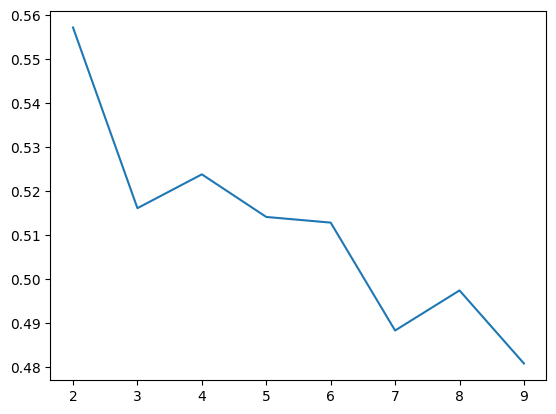

In [39]:
sns.lineplot(results, x=topics, y=coherence)

In [35]:
lda = LdaModel(corpus=corpus, id2word=id2word, num_topics=5, alpha=0.1)
lda.print_topics()

[(0,
  '0.017*"manager" + 0.014*"hour" + 0.012*"bar" + 0.011*"customer" + 0.010*"experience" + 0.008*"table" + 0.008*"staff" + 0.008*"get" + 0.008*"day" + 0.008*"server"'),
 (1,
  '0.011*"customer" + 0.010*"staff" + 0.009*"way" + 0.008*"review" + 0.008*"coffee" + 0.008*"server" + 0.007*"menu" + 0.007*"experience" + 0.007*"drink" + 0.006*"get"'),
 (2,
  '0.013*"burger" + 0.013*"dinner" + 0.011*"price" + 0.010*"waitress" + 0.009*"bar" + 0.009*"night" + 0.009*"chicken" + 0.007*"meal" + 0.007*"experience" + 0.006*"menu"'),
 (3,
  '0.010*"sauce" + 0.009*"eat" + 0.009*"experience" + 0.009*"drive_thru" + 0.009*"thing" + 0.007*"something" + 0.007*"meal" + 0.007*"burger" + 0.007*"star" + 0.007*"day"'),
 (4,
  '0.027*"pizza" + 0.012*"chicken" + 0.010*"way" + 0.010*"meat" + 0.009*"flavor" + 0.008*"sauce" + 0.008*"thing" + 0.008*"bread" + 0.007*"rice" + 0.007*"taste"')]

In [38]:
coherence_model_lda = CoherenceModel(model=lda, texts=data.clean_text, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
coherence_lda

In [56]:
# Visualisation des topics
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(lda, corpus, id2word)

d:\Formation_IA\P6_avis_restau\avis_restau_venv\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.025280  0.053411       1        1  41.570695
1     -0.029272  0.048355       2        1  37.299471
2     -0.049765 -0.086847       3        1  11.575043
3      0.104317 -0.014919       4        1   9.554790, topic_info=           Term         Freq        Total Category  logprob  loglift
446       pizza   597.000000   597.000000  Default  30.0000  30.0000
263      burger   412.000000   412.000000  Default  29.0000  29.0000
771  drive_thru   174.000000   174.000000  Default  28.0000  28.0000
246     manager   773.000000   773.000000  Default  27.0000  27.0000
124     service  1952.000000  1952.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
20        thing    48.587544   664.492955   Topic4  -5.3566  -0.2675
132        half    40.056960   329.952851   Topic4  -5.5497   0.2395
206      minute    47.341882  1075.250204   Topic4  -5.3826  -0.7748
53   restaurant    44.983523  1137.003208   Topic4  -5.4337  -0.8817
165       night    41.663241   660.336077   Topic4  -5.5104  -0.4150

[353 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
1043      4  0.903666     adequate
3979      1  0.061566  advertising
3979      2  0.184697  advertising
3979      3  0.061566  advertising
3979      4  0.738787  advertising
...     ...       ...          ...
99        3  0.083843         year
99        4  0.144396         year
762       1  0.165308    yesterday
762       2  0.805876    yesterday
762       3  0.020663    yesterday

[695 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4])

### Bigrams

In [61]:
# Create Dictionary
id2word = corpora.Dictionary(data.w_bigrams)

# Term Document Frequency

corpus = [id2word.doc2bow(text) for text in data.w_bigrams]

In [43]:
topics = []
coherence = []
perplexity = []

for t in range(2, 10):

    lda = LdaModel(corpus=corpus, id2word=id2word, num_topics=t)

    coherence_model_lda = CoherenceModel(model=lda, texts=data.w_bigrams, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    
    topics.append(t)
    coherence.append(coherence_lda)

results_bg = pd.DataFrame(columns=["Topics", "Coherence"])
results_bg["Topics"] = topics
results_bg["Coherence"] = coherence

<AxesSubplot:>

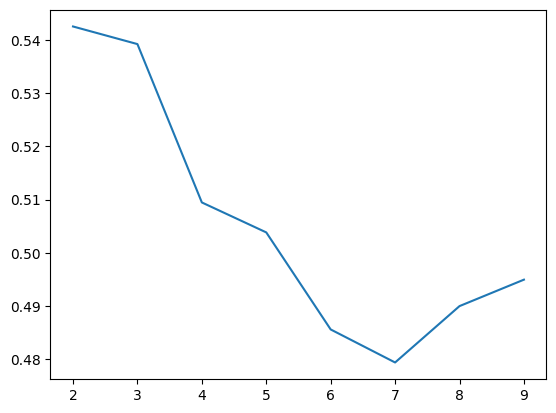

In [44]:
sns.lineplot(results_bg, x=topics, y=coherence)

In [63]:
lda = LdaModel(corpus=corpus, id2word=id2word, num_topics=4)
lda.print_topics()

[(0,
  '0.038*"place" + 0.023*"food" + 0.018*"time" + 0.012*"burger" + 0.012*"restaurant" + 0.010*"service" + 0.009*"price" + 0.008*"night" + 0.008*"salad" + 0.007*"beer"'),
 (1,
  '0.041*"order" + 0.038*"time" + 0.027*"food" + 0.021*"place" + 0.018*"pizza" + 0.018*"service" + 0.015*"minute" + 0.010*"hour" + 0.009*"night" + 0.008*"restaurant"'),
 (2,
  '0.059*"food" + 0.027*"service" + 0.025*"order" + 0.021*"time" + 0.018*"place" + 0.014*"customer" + 0.012*"manager" + 0.011*"minute" + 0.011*"restaurant" + 0.009*"staff"'),
 (3,
  '0.023*"food" + 0.016*"chicken" + 0.013*"place" + 0.010*"restaurant" + 0.009*"flavor" + 0.008*"thing" + 0.008*"sauce" + 0.008*"service" + 0.007*"menu" + 0.007*"piece"')]

In [46]:
# Visualisation des topics
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(lda, corpus, id2word)

d:\Formation_IA\P6_avis_restau\avis_restau_venv\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.060411  0.028227       1        1  35.341647
1     -0.049865  0.041000       2        1  21.762472
2      0.037602 -0.052972       3        1  18.778627
0     -0.015631 -0.069052       4        1  15.145363
4      0.088304  0.052797       5        1   8.971891, topic_info=           Term         Freq        Total Category  logprob  loglift
15         food  4140.000000  4140.000000  Default  30.0000  30.0000
190        meat   362.000000   362.000000  Default  29.0000  29.0000
625       bread   233.000000   233.000000  Default  28.0000  28.0000
119       place  2432.000000  2432.000000  Default  27.0000  27.0000
53   restaurant  1138.000000  1138.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
133        hour    48.275198   758.439420   Topic5  -5.3002  -0.3433
14   everything    39.911280   310.469085   Topic5  -5.4904   0.3596
55    something    42.695223   483.623782   Topic5  -5.4230  -0.0161
165       night    40.351079   668.368250   Topic5  -5.4795  -0.3961
34        order    41.288987  2394.286722   Topic5  -5.4565  -1.6492

[419 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
850       1  0.908552    accommodate
1696      2  0.893486      advertise
1696      5  0.074457      advertise
1384      2  0.933253  advertisement
10        1  0.278636       anything
...     ...       ...            ...
99        1  0.274438           year
99        2  0.274438           year
99        3  0.151174           year
99        4  0.225598           year
99        5  0.076750           year

[898 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 3, 1, 5])

### Trigrams

In [47]:
# Create Dictionary
id2word = corpora.Dictionary(data.w_trigrams)

# Term Document Frequency

corpus = [id2word.doc2bow(text) for text in data.w_trigrams]

In [48]:
topics = []
coherence = []

for t in range(2, 10):

    lda = LdaModel(corpus=corpus, id2word=id2word, num_topics=t)

    coherence_model_lda = CoherenceModel(model=lda, texts=data.w_trigrams, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    
    topics.append(t)
    coherence.append(coherence_lda)

results_tg = pd.DataFrame(columns=["Topics", "Coherence"])
results_tg["Topics"] = topics
results_tg["Coherence"] = coherence

<AxesSubplot:>

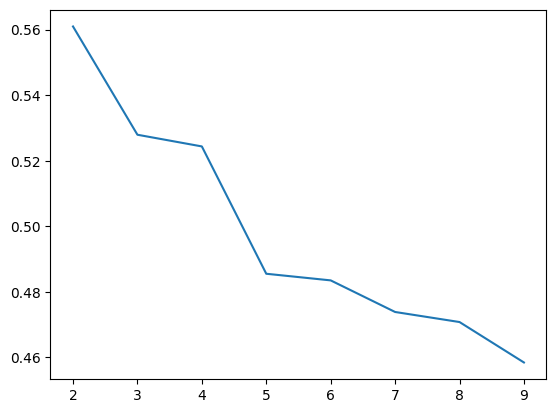

In [49]:
sns.lineplot(results_tg, x=topics, y=coherence)

In [50]:
lda = LdaModel(corpus=corpus, id2word=id2word, num_topics=5)
lda.print_topics()

[(0,
  '0.027*"place" + 0.025*"time" + 0.023*"food" + 0.015*"chicken" + 0.013*"pizza" + 0.012*"order" + 0.009*"room" + 0.008*"roll" + 0.008*"flavor" + 0.008*"restaurant"'),
 (1,
  '0.061*"food" + 0.021*"service" + 0.019*"time" + 0.017*"place" + 0.015*"restaurant" + 0.013*"order" + 0.013*"hour" + 0.010*"price" + 0.009*"customer" + 0.009*"minute"'),
 (2,
  '0.030*"place" + 0.029*"food" + 0.023*"time" + 0.015*"order" + 0.013*"service" + 0.009*"restaurant" + 0.008*"sushi" + 0.007*"menu" + 0.007*"experience" + 0.007*"night"'),
 (3,
  '0.032*"place" + 0.023*"service" + 0.018*"time" + 0.017*"food" + 0.015*"drink" + 0.014*"customer" + 0.013*"burger" + 0.011*"order" + 0.009*"table" + 0.008*"friend"'),
 (4,
  '0.046*"order" + 0.040*"food" + 0.026*"time" + 0.022*"service" + 0.017*"place" + 0.016*"minute" + 0.013*"manager" + 0.011*"restaurant" + 0.010*"location" + 0.009*"thing"')]

In [51]:
# Visualisation des topics
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(lda, corpus, id2word)

d:\Formation_IA\P6_avis_restau\avis_restau_venv\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.003778  0.035226       1        1  27.833182
4     -0.013482  0.061305       2        1  27.548327
2     -0.005764  0.000724       3        1  16.329973
0     -0.081479 -0.056752       4        1  14.330500
3      0.096946 -0.040502       5        1  13.958018, topic_info=           Term         Freq        Total Category  logprob  loglift
119       place  2421.000000  2421.000000  Default  30.0000  30.0000
34        order  2363.000000  2363.000000  Default  29.0000  29.0000
263      burger   426.000000   426.000000  Default  28.0000  28.0000
25      chicken   617.000000   617.000000  Default  27.0000  27.0000
77        drink   668.000000   668.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
220      dinner    75.793079   462.227810   Topic5  -5.2910   0.1611
170       staff    81.478790   614.574585   Topic5  -5.2187  -0.0515
10     anything    68.098055   369.228283   Topic5  -5.3981   0.2786
18        price    67.914060   534.052718   Topic5  -5.4008  -0.0931
109  experience    68.185221   646.242837   Topic5  -5.3968  -0.2798

[431 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
2187      3  0.052499     absolute
2187      4  0.104999     absolute
2187      5  0.839992     absolute
850       4  0.079577  accommodate
850       5  0.875347  accommodate
...     ...       ...          ...
861       1  0.065188         yelp
861       2  0.596007         yelp
861       3  0.139689         yelp
861       4  0.139689         yelp
861       5  0.055876         yelp

[921 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 3, 1, 4])

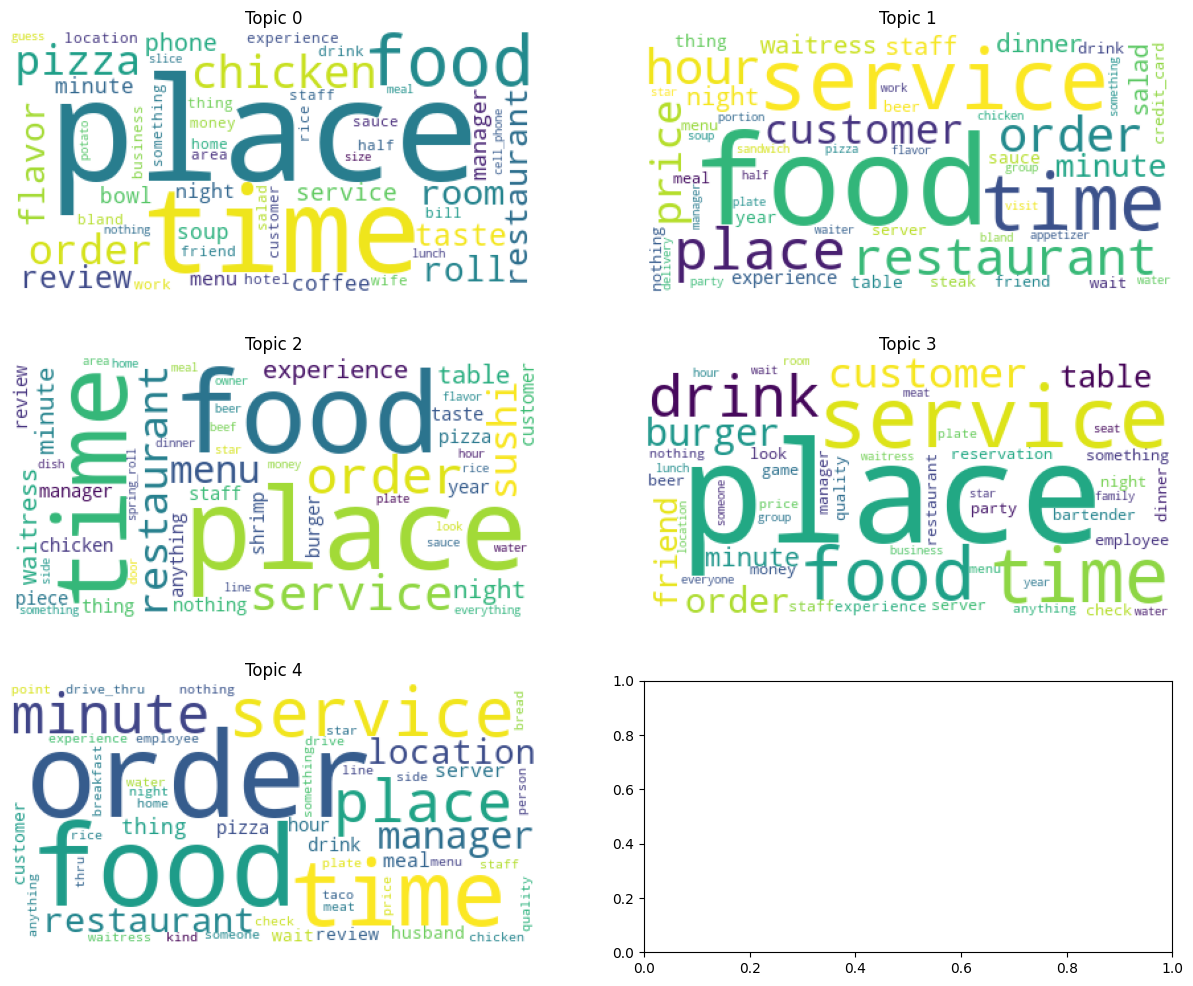

In [52]:
# On affiche le nuage de mots de chaque topic
nbr_rows = int(lda.num_topics/2) if lda.num_topics % 2 == 0 else int((lda.num_topics+1)/2)
index = 1

fig, axs = plt.subplots(nbr_rows, 2, figsize=(15,4*nbr_rows))

for t in range(lda.num_topics):
    plt.subplot(nbr_rows, 2, index)
    plt.imshow(WordCloud(background_color = 'white').fit_words(dict(lda.show_topic(t, 50))))
    plt.axis("off")
    plt.title("Topic " + str(t))

    index+=1

plt.show()